In [1]:
from models.regressionnet_resnet import *
from scripts import tools
from scripts import dataset
from scripts.config import *
import cv2

tools.etc.set_GPU("1")

In [ ]:
net = Regressionnet(data_shape=(128,128,3),num_joints=14,gpu_memory_fraction=None, phase='inference')  

with net.graph.as_default():
    saver = tf.train.Saver()
    saver.restore(net.sess, "./snapshots/Human_Joint_Pointer/Regressionnet_highest_pcp.ckpt")
    
    test_it = dataset.met("./dataset/MET7/met7_test.csv", Bbox=True, Bbox_mode='apply', scale_set=[1.5],
                          re_img_size=(128,128), dataset_root="./dataset/MET7/", Shuffle=False, normalize=True)
    
orig_img_set = dataset.met("./dataset/MET7/met7_test.csv", Bbox=True, Bbox_mode='apply', scale_set=[1.5],
                           re_img_size=(128,128), dataset_root="./dataset/MET7/", Shuffle=False, normalize=False).img_set

INFO:tensorflow:Restoring parameters from ./snapshots/Human_Joint_Pointer/Regressionnet_highest_pcp.ckpt


[Processing Images & Coordinates]:   1%|          | 1/174 [00:00<00:41,  4.17it/s]

In [ ]:
tools.analysis.show_dataset(orig_img_set, test_it.labels.squeeze())

In [ ]:
predicted_joints = net.sess.run(
    [net.fc_regression],
    feed_dict={net.x : test_it.img_set, net.keep_prob:1.0, net.is_train: False})[0]

predicted_joints = predicted_joints.reshape(len(predicted_joints),14,2)
pred_canonical = tools.pose.convert2canonical(predicted_joints)
orig_canonical = tools.pose.convert2canonical(test_it.coor_set.reshape(-1,14,2))

In [ ]:
tools.analysis.get_pcp_stick_result_table_per_activities(test_it.labels, orig_canonical, pred_canonical)

In [ ]:
tools.analysis.show_pcp_result_plot_per_sticks(test_it.labels, orig_canonical, pred_canonical)

In [ ]:
tools.analysis.visualize_Variances_per_joint(test_it.labels, test_it.coor_set, predicted_joints)

In [ ]:
tools.analysis.hist_Variance_Bias_per_joint(test_it.coor_set, predicted_joints)

In [ ]:
tools.analysis.plot_total_pcp_result(test_it.labels, orig_canonical, pred_canonical)

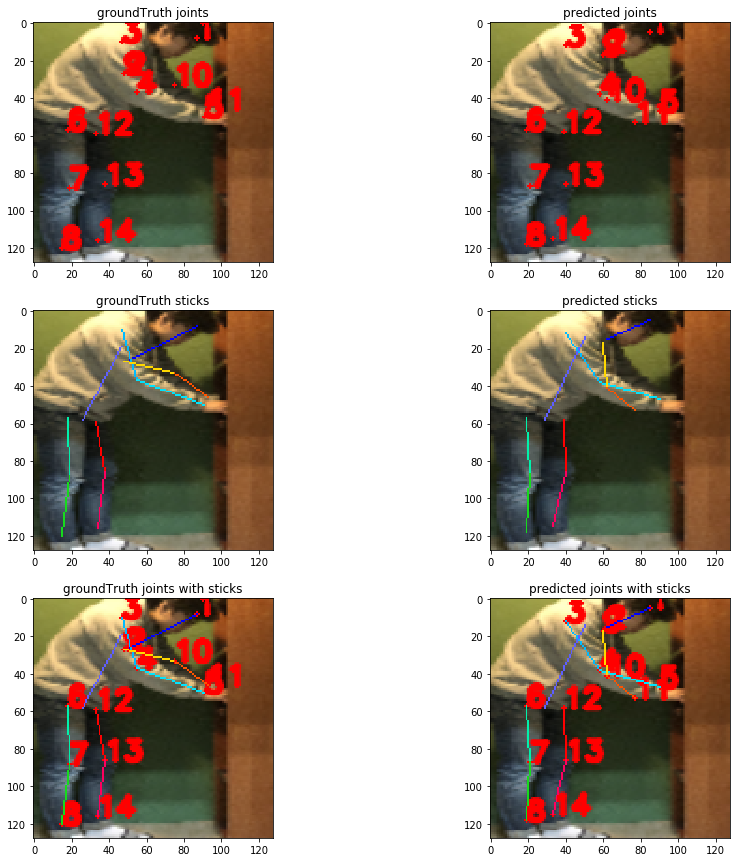

In [10]:
idx=173

tools.analysis.demo_plot(orig_img_set[idx], orig_canonical[idx], pred_canonical[idx], save=False)

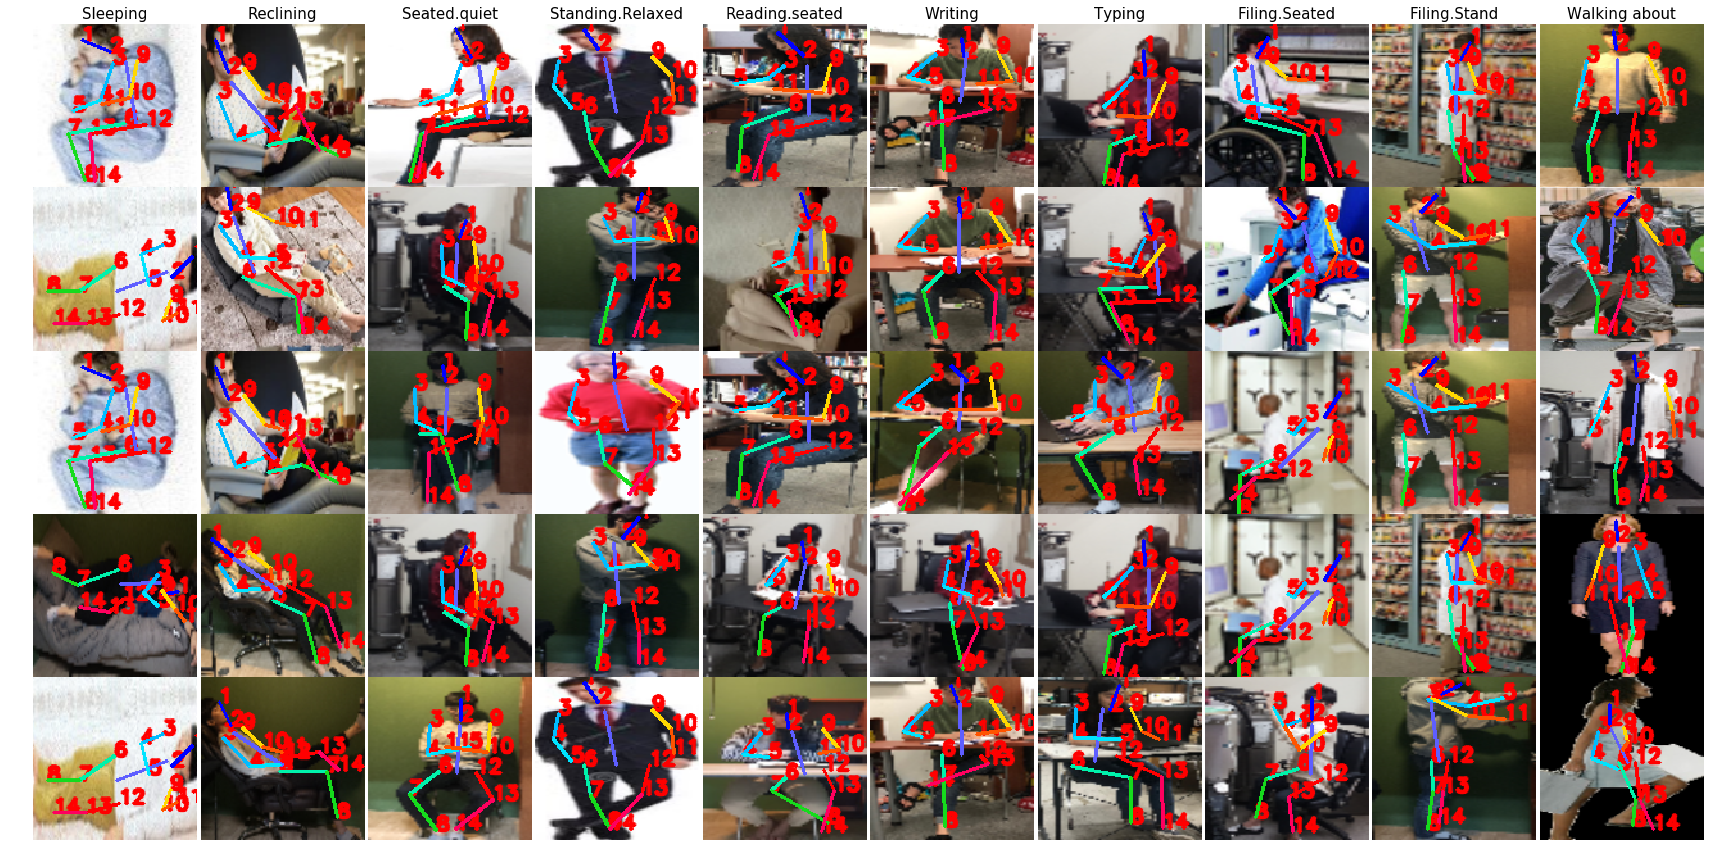

In [12]:
tools.analysis.show_estimated(orig_img_set, test_it.labels.squeeze(), pred_canonical, save=True, save_path='./')